In [1]:
import os
import sys
import time
import torch
import random
import itertools
import dataloader
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import plot_confusion_matrix
from torch.autograd import Variable
import pickle

In [2]:
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename
def load_variavle(filename):
    f=open(filename,'rb')
    r=pickle.load(f)
    f.close()
    return r

In [3]:
def load_data(train_batch_size, test_batch_size):
    train_loader = DataLoader(dataloader.RetinopathyLoader('./data', 'train'), batch_size=train_batch_size)
    test_loader = DataLoader(dataloader.RetinopathyLoader('./data', 'test'), batch_size=test_batch_size)
    
    return (train_loader, test_loader)

def train(model, optimizer, epoch, train_loader, log_interval):
    
    model = model.cuda()
    # State that you are training the model
    model.train()
    criterion = nn.CrossEntropyLoss()
    
    accuracy_sum = 0
    
    # Iterate over batches of data
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.cuda(), target.cuda()
        # Wrap the input and target output in the `Variable` wrapper
        data, target = Variable(data), Variable(target)

        # Clear the gradients, since PyTorch accumulates them
        optimizer.zero_grad()

        # Forward propagation
        output = model(data)

        # Calculate CrossEntropyLoss
        loss = criterion(output.float(), target.long())
        
        #Calculate train accuracy
        accuracy_sum += float((torch.argmax(output, dim=1) == target).sum())
        
        # Backward propagation
        loss.backward()

        # Update the gradients
        optimizer.step()

        # Output debug message
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
            
        
    accuracy_sum /= 28099
    print(f'Epoch: {epoch}  Train accuracy: {accuracy_sum}')
    
    return accuracy_sum
    
def test(model, test_loader):
    
    model = model.cuda()
    # State that you are testing the model; this prevents layers e.g. Dropout to take effect
    model.eval()

    # Init loss & correct prediction accumulators
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    # Optimize the validation process with `torch.no_grad()`
    with torch.no_grad():
        # Iterate over data
        for data, target in test_loader: # Under `torch.no_grad()`, no need to wrap data & target in `Variable`
            data, target = data.cuda(), target.cuda()
            
            # Retrieve output
            output = model(data)

            # Calculate & accumulate loss
            test_loss += criterion(output.float(), target.long()).data.item()

            # Get the index of the max log-probability (the predicted output label)
            pred = output.data.argmax(1)

            # If correct, increment correct prediction accumulator
            correct += pred.eq(target.data).sum()
            

    # Print out average test loss
    test_loss /= len(test_loader.dataset)
    test_acc = correct/len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    print('=====================================================================')
    return test_acc

def test_confuse(model, test_loader):
        
    model = model.cuda()
    # State that you are testing the model; this prevents layers e.g. Dropout to take effect
    model.eval()
    
    # Init loss & correct prediction accumulators
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    true_label, pred_label = [], []
    # Optimize the validation process with `torch.no_grad()`
    with torch.no_grad():
        # Iterate over data
        for data, target in test_loader: # Under `torch.no_grad()`, no need to wrap data & target in `Variable`
            data, target = data.cuda(), target.cuda()
            
            # Retrieve output
            output = model(data)

            # Calculate & accumulate loss
            test_loss += criterion(output.float(), target.long()).data.item()

            # Get the index of the max log-probability (the predicted output label)
            pred = output.data.argmax(1)

            # If correct, increment correct prediction accumulator
            correct += pred.eq(target.data).sum()
            
            #Create true_label and prediction label
            test_output = model(data.float())
            for i in target.cpu().numpy():
                true_label.append(i)
            for i in torch.argmax(test_output, dim=1).cpu().numpy():
                pred_label.append(i)
        
                
    # Print out average test loss
    test_loss /= len(test_loader.dataset)
    test_acc = correct/len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    print('=====================================================================')
    return test_acc, true_label, pred_label

In [179]:
filename1 = save_variable(true_label_18_pretrain,'true_label.txt')
filename2 = save_variable(pred_label_18_pretrain,'pred_18_pretrain.txt')
filename3 = save_variable(pred_label_18_no_pretrain,'pred_18_nopretrain.txt')
filename4 = save_variable(pred_label_50_pretrain,'pred_50_pretrain.txt')
filename5 = save_variable(pred_label_50_no_pretrain,'pred_50_nopretrain.txt')
#g = load_variavle('true_label.txt')

In [5]:
g = load_variavle('pred_50_pretrain.txt')


In [166]:
#ResNet18 with pretrain

pretrain18_train_acc=[]
pretrain18_test_acc=[]
# Instantiate the model
model_18_pretrain = models.resnet18(pretrained=True)
# Choose SGD as the optimizer, initialize it with the parameters & settings
optimizer = optim.SGD(model_18_pretrain.parameters(), lr=0.0001, momentum=0.9)
# Load data
train_loader, test_loader = load_data(4, 4)
epochs=10
# Train & test the model
for epoch in range(1, epochs + 1):
    a = train(model_18_pretrain, optimizer, epoch, train_loader, log_interval=3000)
    pretrain18_train_acc.append(a)
    if (epoch==epochs):
        b, true_label_18_pretrain, pred_label_18_pretrain = test_confuse(model_18_pretrain, test_loader)
        pretrain18_test_acc.append(b)
        for i in range(7025):
            pred_label_18_pretrain[i] = pred_label_18_pretrain[i].item()

    else:
        b = test(model_18_pretrain, test_loader)
        pretrain18_test_acc.append(b)


# Save the model for future use
model_path = os.path.join('.', '/home/ubuntu/DL/lab3/','model_18_pretrain')
torch.save(model_18_pretrain.state_dict(), model_path)

Train Epoch: 1 [0/28099 (0%)]	Loss: 8.875336
Train Epoch: 1 [12000/28099 (43%)]	Loss: 1.218825
Train Epoch: 1 [24000/28099 (85%)]	Loss: 1.684429
Epoch: 1  Train accuracy: 0.735506601658422

Test set: Average loss: 0.1827, Accuracy: 5292/7025 (75%)

Train Epoch: 2 [0/28099 (0%)]	Loss: 0.913336
Train Epoch: 2 [12000/28099 (43%)]	Loss: 0.675525
Train Epoch: 2 [24000/28099 (85%)]	Loss: 1.495800
Epoch: 2  Train accuracy: 0.7596355742197232

Test set: Average loss: 0.1684, Accuracy: 5433/7025 (77%)

Train Epoch: 3 [0/28099 (0%)]	Loss: 0.743707
Train Epoch: 3 [12000/28099 (43%)]	Loss: 0.865557
Train Epoch: 3 [24000/28099 (85%)]	Loss: 1.536684
Epoch: 3  Train accuracy: 0.772198298871846

Test set: Average loss: 0.1622, Accuracy: 5538/7025 (79%)

Train Epoch: 4 [0/28099 (0%)]	Loss: 0.494349
Train Epoch: 4 [12000/28099 (43%)]	Loss: 0.952871
Train Epoch: 4 [24000/28099 (85%)]	Loss: 1.589270
Epoch: 4  Train accuracy: 0.7814157087440834

Test set: Average loss: 0.1632, Accuracy: 5521/7025 (79%)

Tr

In [169]:
#ResNet18 w/o pretrain

no_pretrain18_train_acc=[]
no_pretrain18_test_acc=[]
# Instantiate the model
model_18_no_pretrain = models.resnet18(pretrained=False)
# Choose SGD as the optimizer, initialize it with the parameters & settings
optimizer = optim.SGD(model_18_no_pretrain.parameters(), lr=0.0001, momentum=0.9)
# Load data
train_loader, test_loader = load_data(4, 4)
epochs=10
# Train & test the model
for epoch in range(1, epochs + 1):
    a = train(model_18_no_pretrain, optimizer, epoch, train_loader, log_interval=3000)
    no_pretrain18_train_acc.append(a)

    if(epoch==epochs):
        b, true_label_18_no_pretrain, pred_label_18_no_pretrain = test_confuse(model_18_no_pretrain, test_loader)
        no_pretrain18_test_acc.append(b)
        for i in range(7025):
            pred_label_18_no_pretrain[i] = pred_label_18_no_pretrain[i].item()
    else:
        b = test(model_18_no_pretrain, test_loader)
        no_pretrain18_test_acc.append(b)


# Save the model for future use
model_path = os.path.join('.', '/home/ubuntu/DL/lab3/','model_18_no_pretrain')
torch.save(model_18_no_pretrain.state_dict(), model_path)

Train Epoch: 1 [0/28099 (0%)]	Loss: 7.390179
Train Epoch: 1 [12000/28099 (43%)]	Loss: 0.990575
Train Epoch: 1 [24000/28099 (85%)]	Loss: 1.232478
Epoch: 1  Train accuracy: 0.733122175166376

Test set: Average loss: 0.2168, Accuracy: 5153/7025 (73%)

Train Epoch: 2 [0/28099 (0%)]	Loss: 1.298130
Train Epoch: 2 [12000/28099 (43%)]	Loss: 1.001175
Train Epoch: 2 [24000/28099 (85%)]	Loss: 1.215366
Epoch: 2  Train accuracy: 0.73507954019716

Test set: Average loss: 0.2168, Accuracy: 5153/7025 (73%)

Train Epoch: 3 [0/28099 (0%)]	Loss: 1.313387
Train Epoch: 3 [12000/28099 (43%)]	Loss: 1.022437
Train Epoch: 3 [24000/28099 (85%)]	Loss: 1.181429
Epoch: 3  Train accuracy: 0.7350439517420548

Test set: Average loss: 0.2162, Accuracy: 5153/7025 (73%)

Train Epoch: 4 [0/28099 (0%)]	Loss: 1.271561
Train Epoch: 4 [12000/28099 (43%)]	Loss: 1.048324
Train Epoch: 4 [24000/28099 (85%)]	Loss: 1.120009
Epoch: 4  Train accuracy: 0.7351151286522652

Test set: Average loss: 0.2169, Accuracy: 5153/7025 (73%)

Tra

In [173]:
#ResNet50 with pretrain

pretrain50_train_acc=[]
pretrain50_test_acc=[]
# Instantiate the model
model_50_pretrain = models.resnet50(pretrained=True)
# Choose SGD as the optimizer, initialize it with the parameters & settings
optimizer = optim.SGD(model_50_pretrain.parameters(), lr=0.0001, momentum=0.9)
# Load data
train_loader, test_loader = load_data(4, 4)
epochs=5
# Train & test the model
for epoch in range(1, epochs + 1):
    a = train(model_50_pretrain, optimizer, epoch, train_loader, log_interval=3000)
    pretrain50_train_acc.append(a)

    if (epoch==epochs):
        b, true_label_50_pretrain, pred_label_50_pretrain = test_confuse(model_50_pretrain, test_loader)
        pretrain50_test_acc.append(b)
        for i in range(7025):
            pred_label_50_pretrain[i] = pred_label_50_pretrain[i].item()

    else:
        b = test(model_50_pretrain, test_loader)
        pretrain50_test_acc.append(b)


# Save the model for future use
model_path = os.path.join('.', '/home/ubuntu/DL/lab3/','model_50_pretrain')
torch.save(model_50_pretrain.state_dict(), model_path)

Train Epoch: 1 [0/28099 (0%)]	Loss: 8.694084
Train Epoch: 1 [12000/28099 (43%)]	Loss: 0.979851
Train Epoch: 1 [24000/28099 (85%)]	Loss: 1.663501
Epoch: 1  Train accuracy: 0.745720488273604

Test set: Average loss: 0.1694, Accuracy: 5449/7025 (78%)

Train Epoch: 2 [0/28099 (0%)]	Loss: 0.682424
Train Epoch: 2 [12000/28099 (43%)]	Loss: 0.706575
Train Epoch: 2 [24000/28099 (85%)]	Loss: 1.571645
Epoch: 2  Train accuracy: 0.7743336061781558

Test set: Average loss: 0.1589, Accuracy: 5586/7025 (80%)

Train Epoch: 3 [0/28099 (0%)]	Loss: 0.474549
Train Epoch: 3 [12000/28099 (43%)]	Loss: 0.997202
Train Epoch: 3 [24000/28099 (85%)]	Loss: 1.448488
Epoch: 3  Train accuracy: 0.7879283960283284

Test set: Average loss: 0.1604, Accuracy: 5557/7025 (79%)

Train Epoch: 4 [0/28099 (0%)]	Loss: 0.626504
Train Epoch: 4 [12000/28099 (43%)]	Loss: 1.004281
Train Epoch: 4 [24000/28099 (85%)]	Loss: 1.220987
Epoch: 4  Train accuracy: 0.7978931634577743

Test set: Average loss: 0.1603, Accuracy: 5568/7025 (79%)

T

In [174]:
#ResNet50 w/o pretrain

no_pretrain50_train_acc=[]
no_pretrain50_test_acc=[]
# Instantiate the model
model_50_no_pretrain = models.resnet50(pretrained=False)
# Choose SGD as the optimizer, initialize it with the parameters & settings
optimizer = optim.SGD(model_50_no_pretrain.parameters(), lr=0.0001, momentum=0.9)
# Load data
train_loader, test_loader = load_data(4, 4)
epochs=5
# Train & test the model
for epoch in range(1, epochs + 1):
    a = train(model_50_no_pretrain, optimizer, epoch, train_loader, log_interval=3000)
    no_pretrain50_train_acc.append(a)
  
    if(epoch==epochs):
        b, true_label_50_no_pretrain, pred_label_50_no_pretrain = test_confuse(model_50_no_pretrain, test_loader)
        no_pretrain50_test_acc.append(b)
        for i in range(7025):
            pred_label_50_no_pretrain[i] = pred_label_50_no_pretrain[i].item()
            
    else:
        b = test(model_50_no_pretrain, test_loader)
        no_pretrain50_test_acc.append(b)


# Save the model for future use
model_path = os.path.join('.', '/home/ubuntu/DL/lab3/','model_50_no_pretrain')
torch.save(model_50_no_pretrain.state_dict(), model_path)

Train Epoch: 1 [0/28099 (0%)]	Loss: 6.843099
Train Epoch: 1 [12000/28099 (43%)]	Loss: 1.145851
Train Epoch: 1 [24000/28099 (85%)]	Loss: 1.135900
Epoch: 1  Train accuracy: 0.7315562831417488

Test set: Average loss: 0.2349, Accuracy: 5153/7025 (73%)

Train Epoch: 2 [0/28099 (0%)]	Loss: 1.235226
Train Epoch: 2 [12000/28099 (43%)]	Loss: 1.051372
Train Epoch: 2 [24000/28099 (85%)]	Loss: 1.130119
Epoch: 2  Train accuracy: 0.7331577636214812

Test set: Average loss: 0.2256, Accuracy: 5153/7025 (73%)

Train Epoch: 3 [0/28099 (0%)]	Loss: 1.327533
Train Epoch: 3 [12000/28099 (43%)]	Loss: 1.027339
Train Epoch: 3 [24000/28099 (85%)]	Loss: 1.179982
Epoch: 3  Train accuracy: 0.7334068828072173

Test set: Average loss: 0.2263, Accuracy: 5121/7025 (73%)

Train Epoch: 4 [0/28099 (0%)]	Loss: 1.263421
Train Epoch: 4 [12000/28099 (43%)]	Loss: 1.035087
Train Epoch: 4 [24000/28099 (85%)]	Loss: 1.289607
Epoch: 4  Train accuracy: 0.7340118865440052

Test set: Average loss: 0.2306, Accuracy: 5059/7025 (72%)



In [150]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

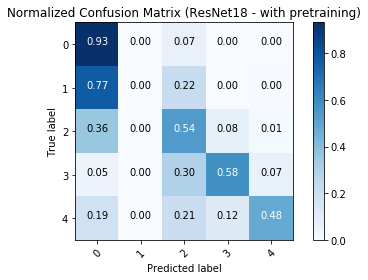

In [180]:
target_names = ['0', '1', '2', '3', '4']
plt.figure()
cnf_matrix = confusion_matrix(true_label_18_pretrain, pred_label_18_pretrain)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True,
                    title='Normalized Confusion Matrix (ResNet18 - with pretraining)')

plt.show()

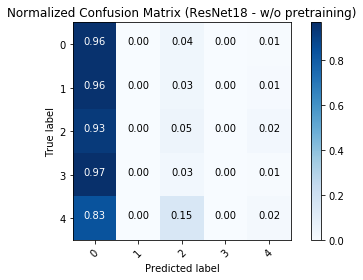

In [181]:
target_names = ['0', '1', '2', '3', '4']
plt.figure()
cnf_matrix = confusion_matrix(true_label_18_no_pretrain, pred_label_18_no_pretrain)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True,
                    title='Normalized Confusion Matrix (ResNet18 - w/o pretraining)')

plt.show()

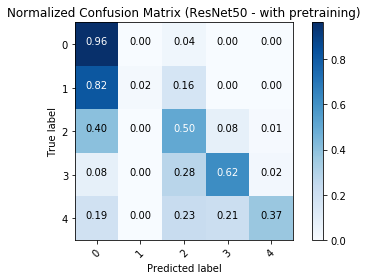

In [182]:
target_names = ['0', '1', '2', '3', '4']
plt.figure()
cnf_matrix = confusion_matrix(true_label_50_pretrain, pred_label_50_pretrain)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True,
                    title='Normalized Confusion Matrix (ResNet50 - with pretraining)')

plt.show()

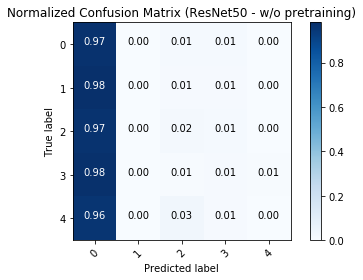

In [183]:
target_names = ['0', '1', '2', '3', '4']
plt.figure()
cnf_matrix = confusion_matrix(true_label_50_no_pretrain, pred_label_50_no_pretrain)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True,
                    title='Normalized Confusion Matrix (ResNet50 - w/o pretraining)')

plt.show()

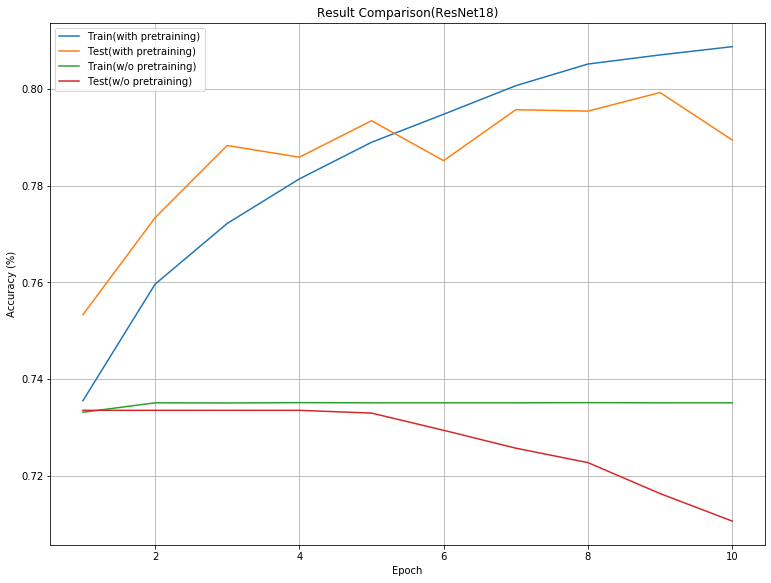

In [184]:
X=[1,2,3,4,5,6,7,8,9,10]

plt.figure(figsize=(12.8, 9.6))
plt.title("Result Comparison(ResNet18)")
plt.ylabel("Accuracy (%)") 
plt.xlabel("Epoch")
plt.plot(X , pretrain18_train_acc , label='Train(with pretraining)')
plt.plot(X , pretrain18_test_acc, label='Test(with pretraining)')
plt.plot(X , no_pretrain18_train_acc, label='Train(w/o pretraining)')
plt.plot(X , no_pretrain18_test_acc, label='Test(w/o pretraining)')
plt.grid()
plt.legend()
plt.show()

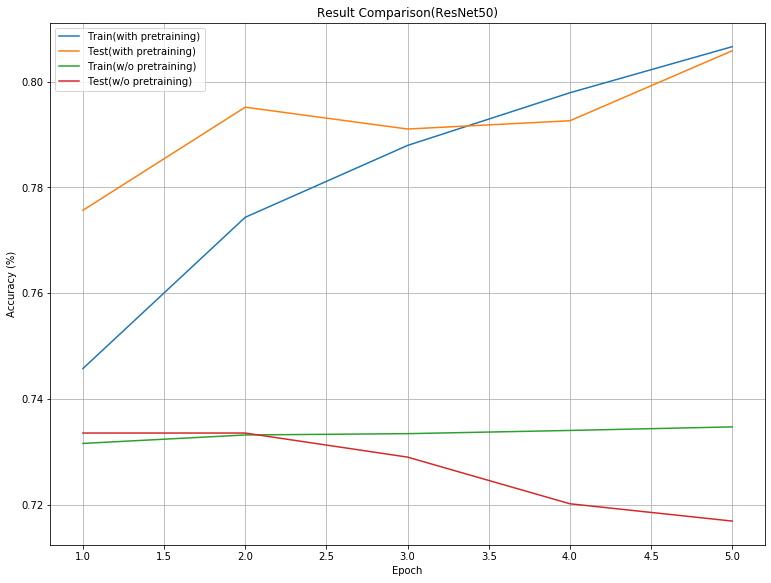

In [185]:
X=[1,2,3,4,5]

plt.figure(figsize=(12.8, 9.6))
plt.title("Result Comparison(ResNet50)")
plt.ylabel("Accuracy (%)") 
plt.xlabel("Epoch")
plt.plot(X , pretrain50_train_acc , label='Train(with pretraining)')
plt.plot(X , pretrain50_test_acc, label='Test(with pretraining)')
plt.plot(X , no_pretrain50_train_acc, label='Train(w/o pretraining)')
plt.plot(X , no_pretrain50_test_acc, label='Test(w/o pretraining)')
plt.grid()
plt.legend()
plt.show()

In [4]:
#For demo part -- load model
PATH1 = os.path.join('.', '/home/ubuntu/DL/lab3/','model_18_pretrain')
model_18_pretrain = models.resnet18(pretrained=True)
model_18_pretrain.load_state_dict(torch.load(PATH1))
model_18_pretrain.eval()

PATH2 = os.path.join('.', '/home/ubuntu/DL/lab3/','model_18_no_pretrain')
model_18_no_pretrain = models.resnet18(pretrained=False)
model_18_no_pretrain.load_state_dict(torch.load(PATH2))
model_18_no_pretrain.eval()

PATH3 = os.path.join('.', '/home/ubuntu/DL/lab3/','model_50_pretrain')
model_50_pretrain = models.resnet50(pretrained=True)
model_50_pretrain.load_state_dict(torch.load(PATH3))
model_50_pretrain.eval()

PATH4 = os.path.join('.', '/home/ubuntu/DL/lab3/','model_50_no_pretrain')
model_50_no_pretrain = models.resnet50(pretrained=False)
model_50_no_pretrain.load_state_dict(torch.load(PATH4))
model_50_no_pretrain.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
#For demo part -- testing data
train_loader, test_loader = load_data(4, 4)
print(f'                 ResNet18 with pretraining')
b = test(model_18_pretrain, test_loader)
print(f'                 ResNet18 w/o pretraining')
b = test(model_18_no_pretrain, test_loader)
print(f'                 ResNet50 with pretraining')
b = test(model_50_pretrain, test_loader)
print(f'                 ResNet50 w/o pretraining')
b = test(model_50_no_pretrain, test_loader)

                 ResNet18 with pretraining

Test set: Average loss: 0.1580, Accuracy: 5546/7025 (79%)

                 ResNet18 w/o pretraining

Test set: Average loss: 0.2337, Accuracy: 4992/7025 (71%)

                 ResNet50 with pretraining

Test set: Average loss: 0.1535, Accuracy: 5661/7025 (81%)

                 ResNet50 w/o pretraining

Test set: Average loss: 0.2332, Accuracy: 5036/7025 (72%)

